# ARIMA

An [AutoRegressive Integrated Moving Average](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model is a popular model used in time series analysis to understand the data or forecast future points.

This implementation can fit a model to each time series in a batch and perform in-sample predictions and out-of-sample forecasts. It is designed to give the best performance when working on a large batch of time series.

Useful links:

- cuDF documentation: https://docs.rapids.ai/api/cudf/stable
- cuML's ARIMA API docs: https://docs.rapids.ai/api/cuml/stable/api.html#arima
- a good introduction to ARIMA: https://otexts.com/fpp2/arima.html

## Setup

### Imports

In [1]:
import cudf
from cuml.tsa.arima import ARIMA

import numpy as np
import pandas as pd
try:
    import matplotlib.pyplot as plt
except ImportError:
    !conda install -c conda-forge -y matplotlib
    import matplotlib.pyplot as plt

### Loading util

The data for this demo is stored in a simple CSV format:
- the data series are stored in columns
- the first column contains the date of the data points
- the first row contains the name of each variable

For example, let's check the *population estimate* dataset:

In [2]:
!cat data/time_series/population_estimate.csv | head

"Year","Male","Female"
1875,238.1,183.2
1876,250.4,194.2
1877,252.5,201.6
1878,264.6,211.5
1879,281.8,225.5
1880,292.3,236.2
1881,299.4,245.7
1882,307.7,254.1
1883,319.0,265.9


We define a helper function to load a dataset with a given name and return a GPU dataframe. We discard the date, and limit the batch size for convenience.

In [3]:
def load_dataset(name, max_batch=4):
    import os
    pdf = pd.read_csv(os.path.join("data", "time_series", "%s.csv" % name))
    return cudf.from_pandas(pdf[pdf.columns[1:max_batch+1]].astype(np.float64))

### Visualization util

We define a helper function that displays the data, and optionally a prediction starting from a given index. Each time series is plot separately for better readability.

In [4]:
def visualize(y, pred=None, pred_start=None, lower=None, upper=None):
    n_obs, batch_size = y.shape
    col = ["#1f77b4", "#ff7f0e"]

    # Create the subplots
    c = min(batch_size, 2)
    r = (batch_size + c - 1) // c
    fig, ax = plt.subplots(r, c, squeeze=False)
    ax = ax.flatten()
    
    # Range for the prediction
    if pred is not None:
        pred_start = pred_start or n_obs
        pred_end = pred_start + pred.shape[0]
    
    # Plot the data
    for i in range(batch_size):
        title = y.columns[i]
        ax[i].plot(np.r_[:n_obs], y[title].to_array(), color=col[0])
        if pred is not None:
            ax[i].plot(np.r_[pred_start:pred_end],
                       pred[pred.columns[i]].to_array(),
                       linestyle="--", color=col[1])
        # Prediction intervals
        if lower is not None and upper is not None:
            ax[i].fill_between(np.r_[pred_start:pred_end],
                               lower[lower.columns[i]].to_array(),
                               upper[upper.columns[i]].to_array(),
                               alpha=0.2, color=col[1])
        ax[i].title.set_text(title)
    for i in range(batch_size, r*c):
        fig.delaxes(ax[i])
    fig.tight_layout()
    plt.show()

## Non-seasonal ARIMA models

A basic `ARIMA(p,d,q)` model is made of three components:
 - An **Integrated** (I) component: the series is differenced `d` times until it is stationary
 - An **AutoRegressive** (AR) component: the variable is regressed on its `p` past values
 - A **Moving Average** (MA) component: the variable is regressed on `q` past error terms

The model can also incorporate an optional constant term (called *intercept*).

### A simple MA(2) example

We start with a simple Moving Average model. Let's first load and visualize the *migrations in Auckland by age* dataset:

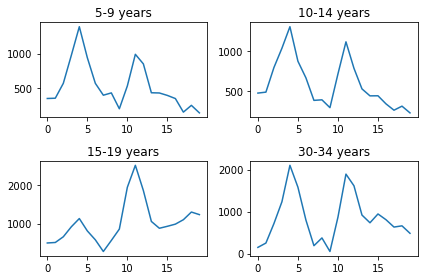

In [5]:
df_mig = load_dataset("net_migrations_auckland_by_age", 4)
visualize(df_mig)

We want to fit the model with `q`=2 and with an intercept.
The `ARIMA` class accepts cuDF dataframes or array-like types as input (host or device), e.g numpy arrays. Here we already have a dataframe so we can simply pass it to the `ARIMA` constructor with the model parameters:

In [6]:
model_mig = ARIMA(df_mig, (0,0,2), fit_intercept=True)
model_mig.fit()

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass order=(0, 0, 2) as keyword args. From version 0.20, passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


ARIMA()

We can now forecast and visualize the results:

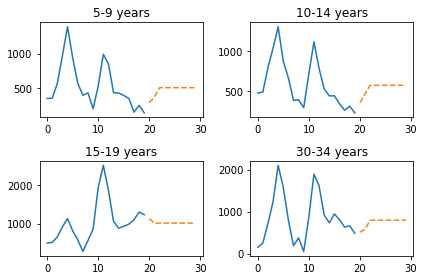

In [7]:
fc_mig = model_mig.forecast(10)
visualize(df_mig, fc_mig)

If we want to get the parameters that were fitted to the model, we can use `get_fit_params` or the corresponding properties. The parameters are organized in 2D arrays: one row represents one parameter and the columns are different batch members.

In [8]:
print(model_mig.get_fit_params()["ma"])
print(model_mig.ma_)

          0         1         2         3
0  1.310065  1.106705  1.179771  1.248473
1  0.901776  0.739677  0.683326  0.761904
          0         1         2         3
0  1.310065  1.106705  1.179771  1.248473
1  0.901776  0.739677  0.683326  0.761904


It is also possible to get a compact numpy array containing all the parameters with `pack`, or similarly to load the parameters into a model with `unpack`:

In [9]:
print(model_mig.pack())

[5.11633170e+02 1.31006469e+00 9.01776207e-01 3.71857357e+04
 5.69574425e+02 1.10670510e+00 7.39677479e-01 4.10079158e+04
 1.01434009e+03 1.17977087e+00 6.83325993e-01 1.24248421e+05
 7.95116363e+02 1.24847255e+00 7.61904330e-01 1.21165443e+05]


We can also get the log-likelihood of the parameters w.r.t to the series, and evaluate various information criteria:

In [10]:
print("log-likelihood:\n", model_mig.llf)
print("\nAkaike Information Criterion (AIC):\n", model_mig.aic)
print("\nCorrected Akaike Information Criterion (AICc):\n", model_mig.aicc)
print("\nBayesian Information Criterion (BIC):\n", model_mig.bic)

log-likelihood:
 [-133.82681706 -133.64679738 -142.79391832 -146.82119293]

Akaike Information Criterion (AIC):
 0    275.653634
1    275.293595
2    293.587837
3    301.642386
dtype: float64

Corrected Akaike Information Criterion (AICc):
 0    278.320301
1    277.960261
2    296.254503
3    304.309053
dtype: float64

Bayesian Information Criterion (BIC):
 0    279.636563
1    279.276524
2    297.570766
3    305.625315
dtype: float64


### An ARIMA(1,2,1) example

Let's now load the *population estimate* dataset. For this dataset a first difference is not enough to make the data stationary because of the quadratic trend, so we decide to go with `d`=2.

This time we won't simply forecast but also predict in-sample:

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Pass order=(1, 2, 1) as keyword args. From version 0.20, passing these as positional arguments will result in an error
  after removing the cwd from sys.path.


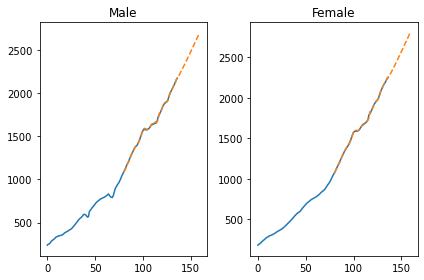

In [11]:
df_pop = load_dataset("population_estimate")

# Fit an ARIMA(1,2,1) model
model_pop = ARIMA(df_pop, (1,2,1), fit_intercept=True)
model_pop.fit()

# Predict in-sample and forecast out-of-sample
pred_pop = model_pop.predict(80, 160)
visualize(df_pop, pred_pop, 80)

### Confidence intervals

To get confidence intervals when forecasting, we can specify the confidence level (here 95%):

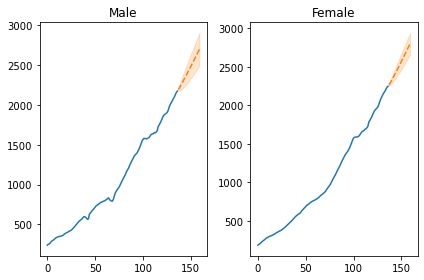

In [12]:
fc_pop, lower_pop, upper_pop = model_pop.forecast(23, level=0.95)
visualize(df_pop, fc_pop, lower=lower_pop, upper=upper_pop)

## Seasonal ARIMA models

[Seasonal ARIMA models](https://otexts.com/fpp2/seasonal-arima.html) are expressed in the form `ARIMA(p,d,q)(P,D,Q)s` and have additional seasonal components that we denote SAR and SMA.

We can also choose to apply a first or second seasonal difference, or combine a non-seasonal and a seasonal difference (note: `p+P <= 2` is required).

### An ARIMA(1,1,1)(1,1,1)12 example

We load the *guest nights by region* dataset. This dataset shows a strong seasonal component with a period of 12 (annual cycle, monthly data), and also a non-seasonal trend. A good choice is to go with `d`=1, `D`=1 and `s`=12.

We create the model with seasonal parameters, and forecast:

In [13]:
df_guests = load_dataset("guest_nights_by_region", 4)

# Create and fit an ARIMA(1,1,1)(1,1,1)12 model:
model_guests = ARIMA(df_guests, (1,1,1), (1,1,1,12), fit_intercept=False)
model_guests.fit()

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Pass order=(1, 1, 1), seasonal_order=(1, 1, 1, 12) as keyword args. From version 0.20, passing these as positional arguments will result in an error
  after removing the cwd from sys.path.


ARIMA()

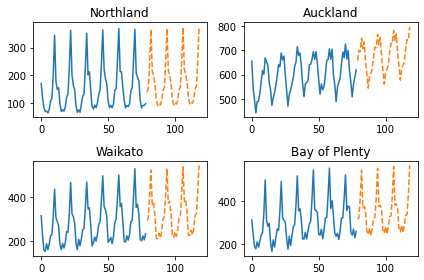

In [14]:
# Forecast
fc_guests = model_guests.forecast(40)

# Visualize after the time step 200
visualize(df_guests[200:], fc_guests)